In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
% matlotlib inline

ModuleNotFoundError: No module named 'numpy'

In [77]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return self - other

    def __neg__(self):
        return self * -1

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other ** -1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * out.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [76]:
a = Value(2.0)
b = Value(4.0)
a / b


Value(data=0.5)

In [3]:
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), (str(id(n2)) + n2._op))

    return dot

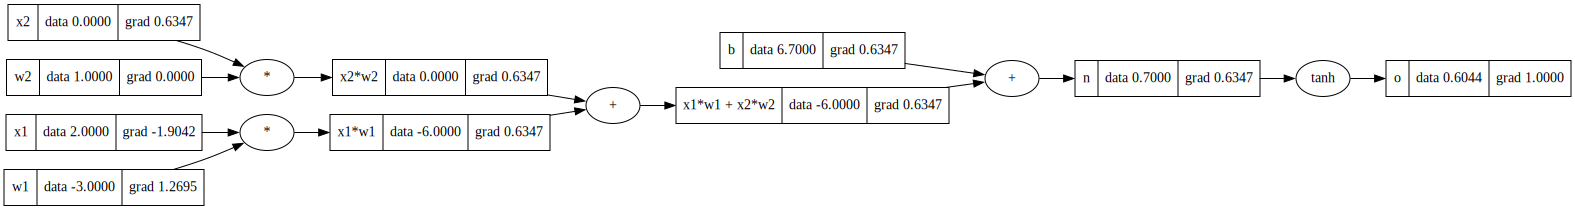

In [79]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.7, label='b')
x1w1 = x1 * w1;
x1w1.label = 'x1*w1'
x2w2 = x2 * w2;
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2;
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b;
n.label = 'n'
o = n.tanh();
o.label = 'o'
o.backward()
draw_dot(o)


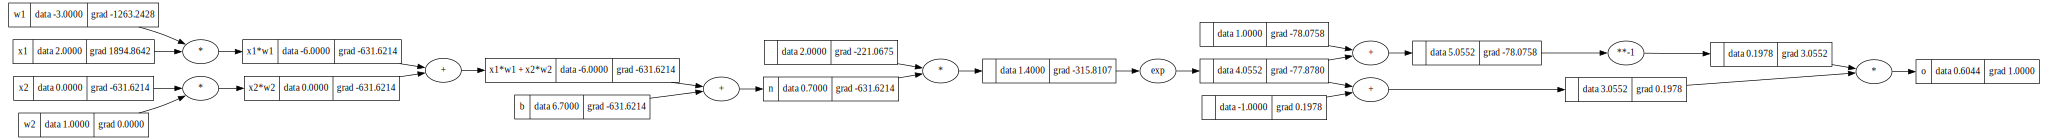

In [80]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.7, label='b')
x1w1 = x1 * w1;
x1w1.label = 'x1*w1'
x2w2 = x2 * w2;
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2;
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b;
n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()
draw_dot(o)

In [43]:
o.grad = 1.0

topo = []
visited = set()


def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)


build_topo(o)

for node in reversed(topo):
    node._backward()

In [37]:
topo = []
visited = set()


def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)


build_topo(o)
topo

[Value(data=6.7),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.7000000000000002),
 Value(data=0.6043677771171636)]

In [0]:
o.grad = 1

In [29]:
o._backward()

In [31]:
n._backward()

In [33]:
x1w1x2w2._backward()

In [35]:
x2w2._backward()
x1w1._backward()

In [19]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [12]:
1 - o.data ** 2

0.6347395899824584